In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
from sklearn.cluster import DBSCAN, OPTICS, AgglomerativeClustering
from sklearn import metrics
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler
from pathlib import Path
import matplotlib as mpl
from matplotlib import cm
import matplotlib.colors as colors
import matplotlib.cbook as cbook
import time
import sys


SET_N_TRHEADS = 8

# Cluster generation

Text(0, 0.5, 'Row')

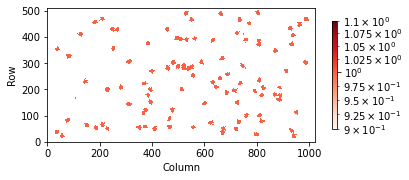

In [2]:
def makeCluster(wx, wy, npix, nclusters = 1):
    cluster=[]
    total_area=0
    for nc in range(nclusters):
        x = np.random.normal(0, wx, npix*5)
        y = np.random.normal(0, wy, npix*5)
        cx = np.random.randint(int(wx*5), 1023-int(wx*5))
        cy = np.random.randint(int(wy*5),  511-int(wy*5))
        angle = np.random.uniform(0, np.pi, npix*5)
        xr = x*np.cos(angle)+y*np.sin(angle)+cx
        yr = y*np.cos(angle)-x*np.sin(angle)+cy
        x = xr.astype(int)
        y = yr.astype(int)
        
        k = 0
        for i in range(len(x)):
            if ([x[i],y[i]]) not in cluster:
                k+=1
                cluster.append([x[i],y[i]])
        if k == 1: #delete cluster with area 1
            cluster.pop()
        else:
            total_area+=k
        
    return cluster, total_area 

def makeNoise(Noise_points):
    noise=[]
    for i in range(Noise_points):
        nx = np.random.randint(0,1024)
        ny = np.random.randint(0, 512)
        noise.append([nx,ny])
        
    return noise

    
cluster, tot_ar= makeCluster(3,3,10,100)
noise = makeNoise(2)
real=np.append(cluster,noise,axis=0)


#generate the hitmap
cluster_matrix=np.zeros((512,1024))
for pixel in real:
    x=pixel[0]
    y=pixel[1]
    cluster_matrix[y,x] += 1

#and plot it
fig, ax = plt.subplots()
colormap = cm.get_cmap('Reds')
psm = ax.pcolormesh(cluster_matrix, cmap=colormap, norm=colors.LogNorm(), vmin=1, vmax=np.max(cluster_matrix))
cbar=plt.colorbar(psm, shrink=0.5, ax=ax)
#cbar.set_label("N. hits")
plt.axis('scaled')
ax.set(xlim=(0, 1023), ylim=(0, 511))
plt.xlabel("Column")
plt.ylabel("Row")




# Clusterin Algorithm

In [87]:
def findClusterDB_old(X, distance):
    db = DBSCAN(eps=distance, min_samples=2, n_jobs=1).fit(X)
    core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
    core_samples_mask[db.core_sample_indices_] = True
    labels = db.labels_
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise_ = list(labels).count(-1)
    nc = 0
    #initialize an empty list to accomodate the sample coordinates whitin the cluster
    clusters = [[] for _ in range(n_clusters_)]
    #total_clusters += n_clusters_
    #total_noise_points += n_noise_
    for j in range(len(db.labels_)):
        if db.labels_[j] == -1:	#noise sample has label -1
            nc = nc + 1	#noise counter
        else: 
            index = db.labels_[j]
            #print(db.components_[j-nc])
            clusters[index].append(np.array(db.components_[j - nc])) 
    Areas=[]
    for j in range(len(clusters)):
        Areas.append(len(clusters[j]))
    return clusters, Areas, nc

def findClusterDB(X, distance):
    db = DBSCAN(eps=distance, min_samples=2).fit(X)
    clusters = np.column_stack((X, db.labels_))
    nc = np.sum(clusters[:,2]==-1)
    Noise_inds=np.where(clusters[:,2]==-1)
    clusters=np.delete(clusters,Noise_inds,axis=0)
    labels=np.delete(db.labels_,Noise_inds,axis=0)
    unique, Areas = np.unique(labels, return_counts=True)

    return clusters, Areas, nc

def findClusterAgg(X, distance):
    agg = AgglomerativeClustering(n_clusters=None, distance_threshold=distance, compute_full_tree=True).fit(X)
    clusters = np.column_stack((X, agg.labels_))
    unique, Areas = np.unique(agg.labels_, return_counts=True)
    Area_noise_inds=np.where(Areas==1)
    if np.sum(Area_noise_inds) != 0:
        Noise_inds=np.where(clusters[:,2]==Area_noise_inds)
        nc=np.sum(Area_noise_inds)
        if len(Noise_inds) != 0:
            Noise_inds=np.delete(Noise_inds,0,axis=0)#Non so perché ma sto aborto si prende pure il primo elemento
            clusters=np.delete(clusters,Noise_inds,axis=0)
            labels=np.delete(agg.labels_,Noise_inds,axis=0)
            unique, Areas = np.unique(labels, return_counts=True)
    else:
        nc=0
    
    
    return clusters, Areas, nc
        
def findClusterOPTICS(X, distance):
    opt = OPTICS(eps=distance, min_samples=2, n_jobs=1).fit(X)
    clusters = np.column_stack((X, opt.labels_))
    unique, Areas = np.unique(clusters, return_counts=True)
    nc = np.sum(clusters[:,2]==-1)
     
    return clusters, Areas, nc
        

# Packet decoder simulation with DBSCAN

Completeness : 100.0%
Noise points injected:  800000
Noise points found:  796904
Execution time:  3456.2750267982483
Exact area:  17.523287216204473
Mean area:  17.585883661604786
Missclassified:  0.3519417199618686 %


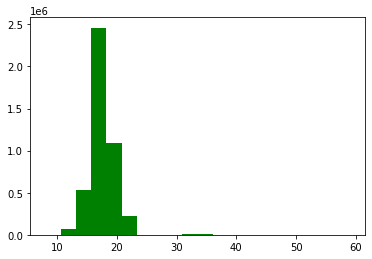

In [189]:
N=800000
patience = 10
npp=1#noise ponits per packet
Areas=[]
t = time.time()
Tot_area_sim=0
Tot_packets=0
Tot_noise=0
tot_clust_inj = 0
tot_missclass = 0

for i in range(N):
    if ( i % patience == 0 ):
        sys.stdout.write("\rCompleteness : "+str(round(i/N*100,1))+"%")
    Npackets=np.random.randint(1,11)
    clust, Area_sim=makeCluster(1.5,1.5,5,Npackets)
    noise=makeNoise(npp)
    realclust=np.append(clust,noise,axis=0)
    Tot_area_sim+=Area_sim
    Tot_packets+=Npackets
    ClusterDC, AreaCluster, nc=findClusterDB(realclust,8)
    Areas=np.append(Areas,AreaCluster)
    tot_missclass += np.abs(len(np.unique(ClusterDC[:,2])) - Npackets)
    tot_clust_inj += Npackets
    Tot_noise+=nc

n, bins, patches = plt.hist(Areas, 20, facecolor='g')

print("")
print("Noise points injected: ", N*npp)
print("Noise points found: ", Tot_noise)
print("Execution time: ", time.time()-t)
print("Exact area: ", Tot_area_sim/Tot_packets)
print("Mean area: ", np.mean(Areas))
print("Missclassified: ", tot_missclass/tot_clust_inj*100, "%")

[0 1 2 3 4 5]


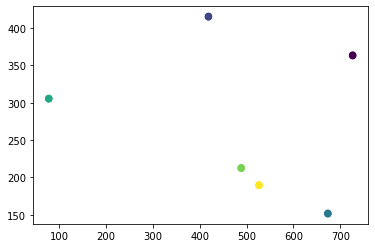

In [166]:
Npackets=np.random.randint(1,10)
clust, Area_sim=makeCluster(0.1,0.1,15,Npackets)
ClusterDC, AreaCluster, _=findClusterDB(clust,1)
plt.scatter(ClusterDC[:,0], ClusterDC[:,1], c=ClusterDC[:,2])

print(np.unique(ClusterDC[:,2]))

# Packet decoder simulation with Agglomerative Clustering

Completeness : 100.0%
Noise points injected:  800000
Noise points found:  800000
Execution time:  2610.839242696762
Exact area:  17.524340615330175
Mean area:  17.53259210183246
Missclassified:  0.03998131476211118 %


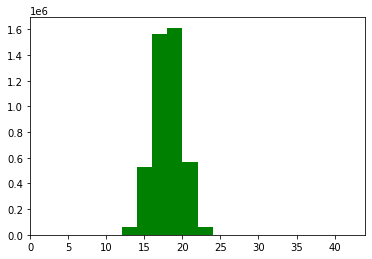

In [190]:
N=800000
patience = 10
npp=1#noise ponits per packet
Areas=[]
t = time.time()
Tot_area_sim=0
Tot_packets=0
Tot_noise=0
tot_clust_inj = 0
tot_missclass = 0

for i in range(N):
    if ( i % patience == 0 ):
        sys.stdout.write("\rCompleteness : "+str(round(i/N*100,1))+"%")
    Npackets=np.random.randint(1,11)
    clust, Area_sim=makeCluster(1.5,1.5,5,Npackets)
    noise=makeNoise(npp)
    realclust=np.append(clust,noise,axis=0)
    ClusterDC, AreaCluster, nc=findClusterAgg(realclust,20)
    Tot_area_sim+=Area_sim
    Tot_packets+=Npackets
    Areas=np.append(Areas,AreaCluster)
    tot_missclass += np.abs(len(np.unique(ClusterDC[:,2])) - Npackets)
    tot_clust_inj += Npackets
    Tot_noise+=nc  

n, bins, patches = plt.hist(Areas, 20, facecolor='g')

print("")
print("Noise points injected: ", N*npp)
print("Noise points found: ", Tot_noise)
print("Execution time: ", time.time()-t)
print("Exact area: ", Tot_area_sim/Tot_packets)
print("Mean area: ", np.mean(Areas))
print("Missclassified: ", tot_missclass/tot_clust_inj*100, "%")

[[5]]
[0 1 2 3 4]


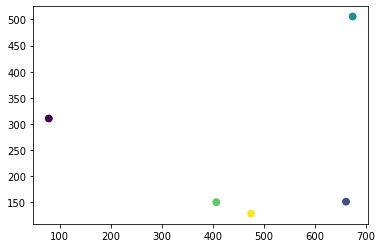

In [71]:
Npackets=5#np.random.randint(5,10)
clust, Area_sim=makeCluster(0.1,0.1,15,Npackets)
noise=makeNoise(1)
realclust=np.append(clust,noise,axis=0)
ClusterDC, AreaCluster, _=findClusterAgg(realclust,20)
plt.scatter(ClusterDC[:,0], ClusterDC[:,1], c=ClusterDC[:,2])

print(np.unique(ClusterDC[:,2]))

In [68]:
#LENTOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO

#N=10000
#patience = 10
#Areas=[]
#t = time.time()
#
#for i in range(N):
#    if ( i % patience == 0 ):
#        sys.stdout.write("\rCompleteness : "+str(round(i/N*100,1))+"%")
#    Npackets=np.random.randint(5,10)
#    clust=makeCluster(3,6,15,4,Npackets)
#    ClusterDC, AreaCluster, _=findClusterOPTICS(clust,10)
#    Areas=np.append(Areas,AreaCluster)
#
#print("")  
#print(time.time()-t)
#print(np.mean(Areas))

In [76]:
i = 0
total_clusters = 0
total_noise_points = 0
while True:
    file_name="file{0:0d}.npy".format(i)
    my_file = Path(file_name)
    if my_file.is_file():
        i += 1
        packet = np.load(file_name, allow_pickle=True)
        print(len(packet[0]))
        clusters = findClusterDB(packet)
        clusters = findClusterAC(packet)
    else:
        print ("No more packets")
        break

No more packets


0.0

1